# Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup
import re,string,unicodedata
from collections import Counter
from pathlib import Path

In [2]:
from IPython.display import HTML
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 6)

HTML("""
<style>
.container { width:100% !important; }
.output_png { display: block; margin-left: auto; margin-right: auto; }
</style>
""")

## Reading the csv 

In [3]:
notebook_dir = Path().resolve()
csv_path = notebook_dir.parent / "data" / "IMDB_Dataset.csv"

data = pd.read_csv(csv_path)

### Checking the data

In [4]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
data.describe(include="all").T

,count,unique,top,freq
review,50000,49582,Loved today's show!!! It was a variety and not...,5
sentiment,50000,2,positive,25000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
null_values = data.isnull().sum()
print(f"There are {null_values[0]} missing values for {null_values.index[0]} and {null_values[1]} for {null_values.index[1]}.")

There are 0 missing values for review and 0 for sentiment.


In [8]:
num_duplicates = data.duplicated().sum() #identify duplicates
print(f"There are {num_duplicates} duplicate reviews present in the dataset")

There are 418 duplicate reviews present in the dataset


In [9]:
review_data = data['review']
duplicated_review = data[review_data.isin(review_data[review_data.duplicated()])].sort_values("review")
duplicated_review.head()

,review,sentiment
34058,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
47467,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
29956,"""Three"" is a seriously dumb shipwreck movie. M...",negative
31488,"""Three"" is a seriously dumb shipwreck movie. M...",negative
47527,"""Witchery"" might just be the most incoherent a...",negative


In [10]:
data.drop_duplicates(inplace = True)
print('The dataset contains {} rows and {} columns after removing duplicates'.format(data.shape[0],data.shape[1]))

The dataset contains 49582 rows and 2 columns after removing duplicates


In [11]:
sys.path.append(str(notebook_dir.parent / "src"))
from preprocessor.preprocessing import IMDBPreprocessor

In [12]:
preprocessor = IMDBPreprocessor()

In [13]:
backup_data = data.copy()

data["review"] = data["review"].apply(preprocessor.preprocess)

In [14]:
data["sentiment"] = [1 if sentiment == "positive" else 0 for sentiment in data["sentiment"]]

In [15]:
data.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake thinks zombie...,0
4,petter matteis love time money visually stunni...,1


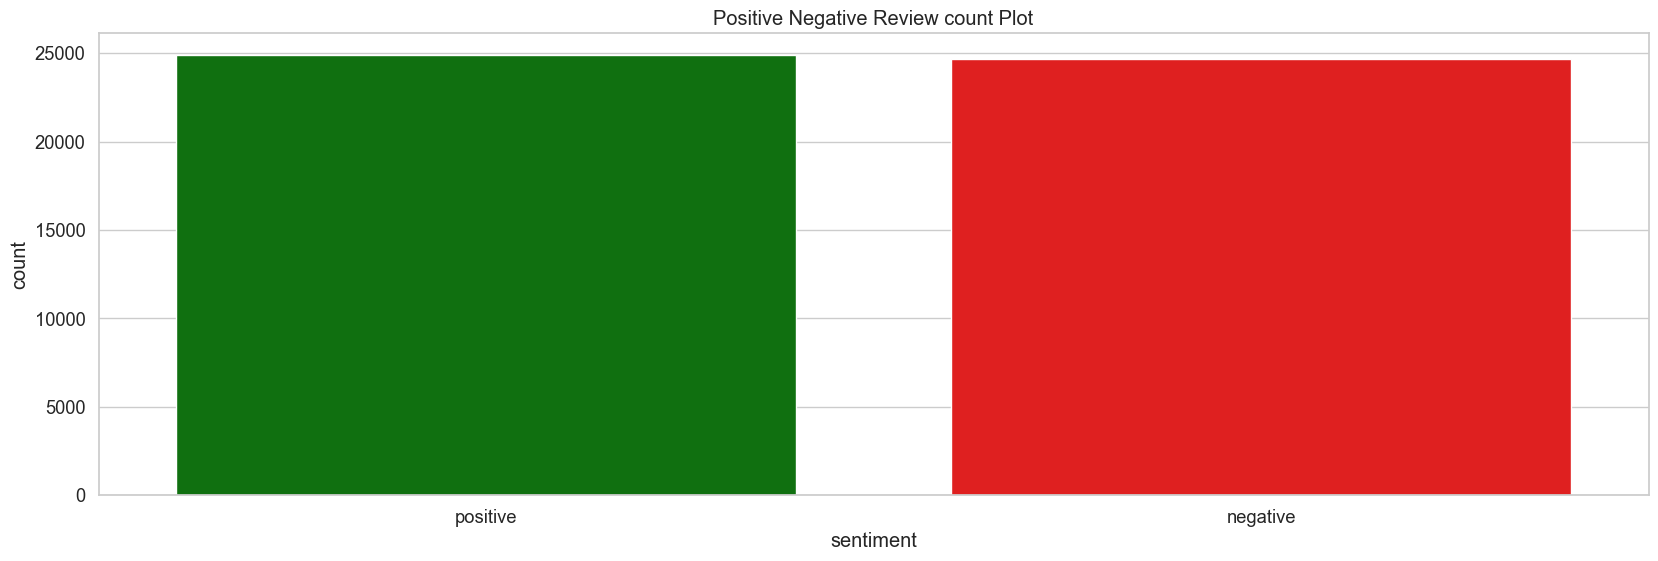

In [16]:
sns.set(style = "whitegrid" , font_scale = 1.2)
sns.countplot(data, x="sentiment", palette = ['green','red'],order = [1,0])
plt.xticks(ticks = np.arange(2),labels = ['positive','negative'])
plt.title('Positive Negative Review count Plot')
plt.show()

In [17]:
print(f"Positive reviews are {round(data['sentiment'].value_counts()[0])} i.e. {round(data['sentiment'].value_counts()[0]/len(data) * 100,2)} % of the dataset")
print(f"Negative reviews are {round(data['sentiment'].value_counts()[1])} i.e. {round(data['sentiment'].value_counts()[1]/len(data) * 100,2)} % of the dataset")

Positive reviews are 24698 i.e. 49.81 % of the dataset
Negative reviews are 24884 i.e. 50.19 % of the dataset


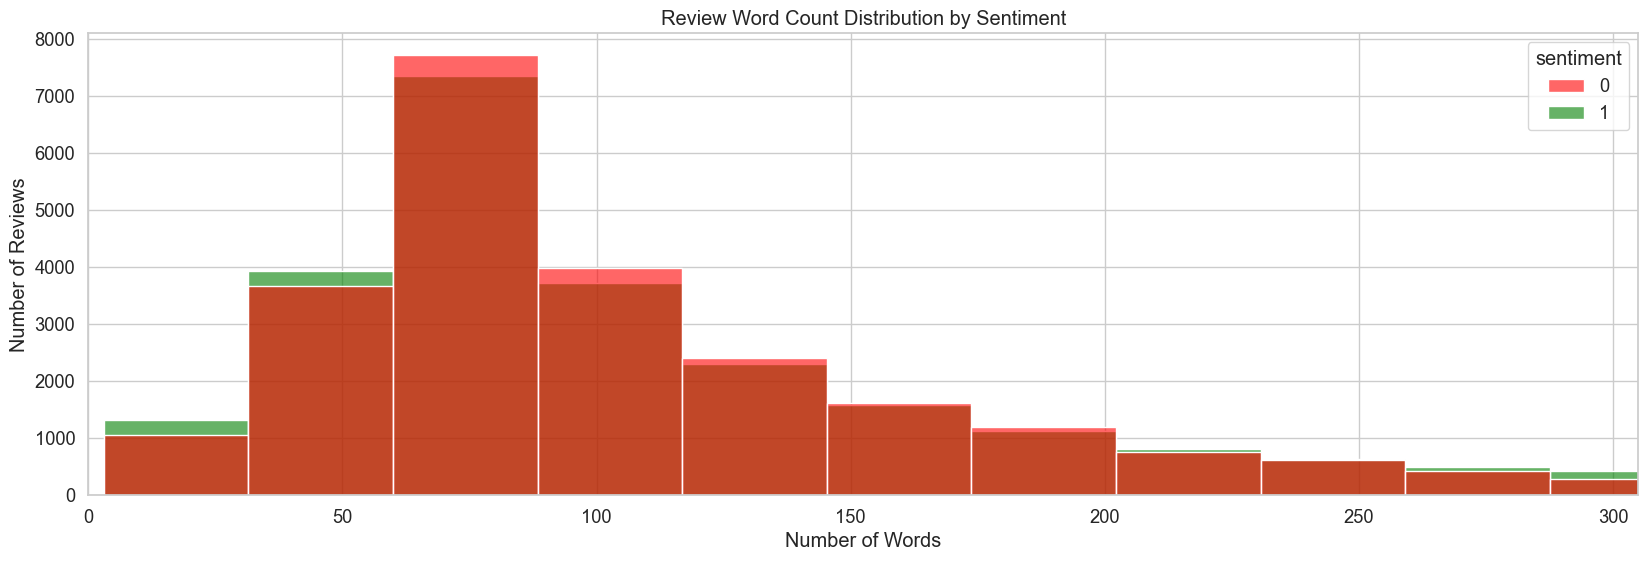

In [18]:
data["review_word_count"] = data["review"].str.split().str.len()
data["review_char_count"] = data["review"].str.len()


#plt.figure(figsize=(14, 6))
sns.histplot(
    data=data,
    x="review_word_count",
    hue="sentiment",
    bins=50,
    palette={1: "green", 0: "red"},
    alpha=0.6
)
plt.title("Review Word Count Distribution by Sentiment")
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.xlim(0, data["review_word_count"].quantile(0.95))
plt.show()

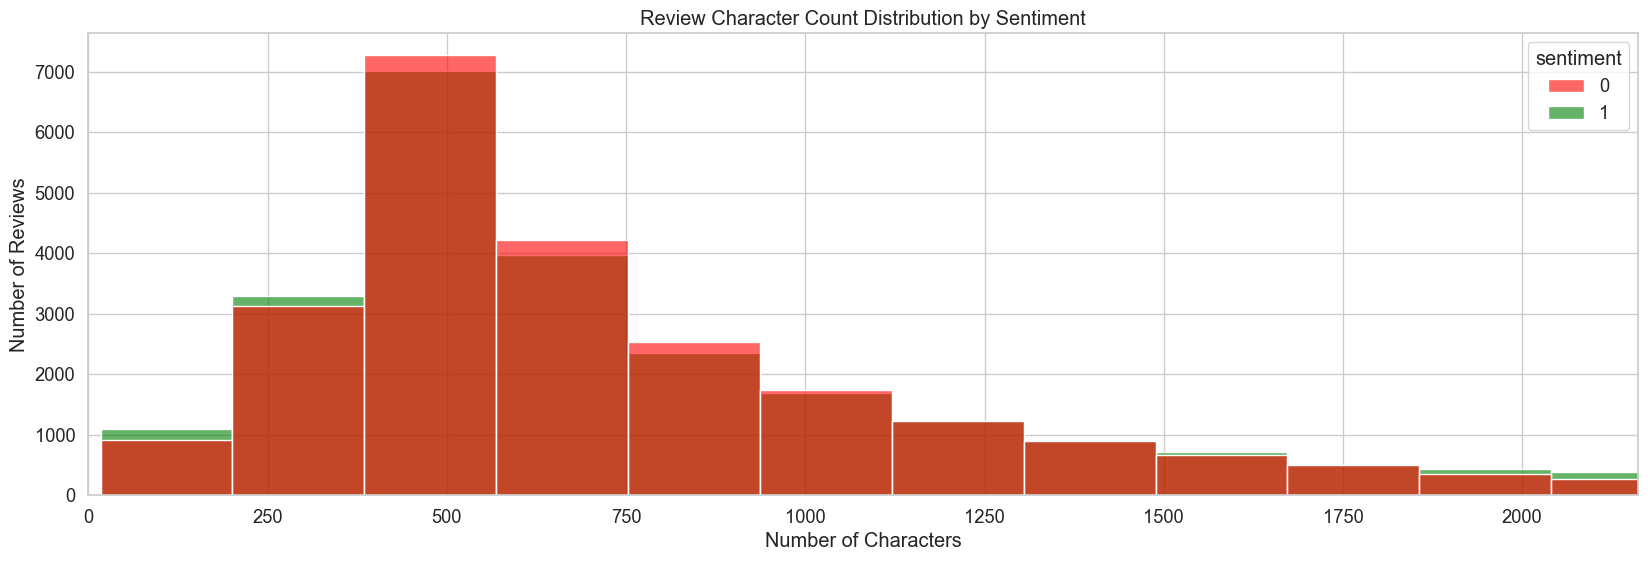

In [19]:
sns.histplot(
    data=data,
    x="review_char_count",
    hue="sentiment",
    bins=50,
    palette={1: "green", 0: "red"},
    alpha=0.6
)
plt.title("Review Character Count Distribution by Sentiment")
plt.xlabel("Number of Characters")
plt.ylabel("Number of Reviews")
plt.xlim(0, data["review_char_count"].quantile(0.95))
plt.show()

In [20]:
all_words = " ".join(data["review"]).split()
word_freq = Counter(all_words)
common_words_df = pd.DataFrame(word_freq.most_common(20), columns=["word", "count"])

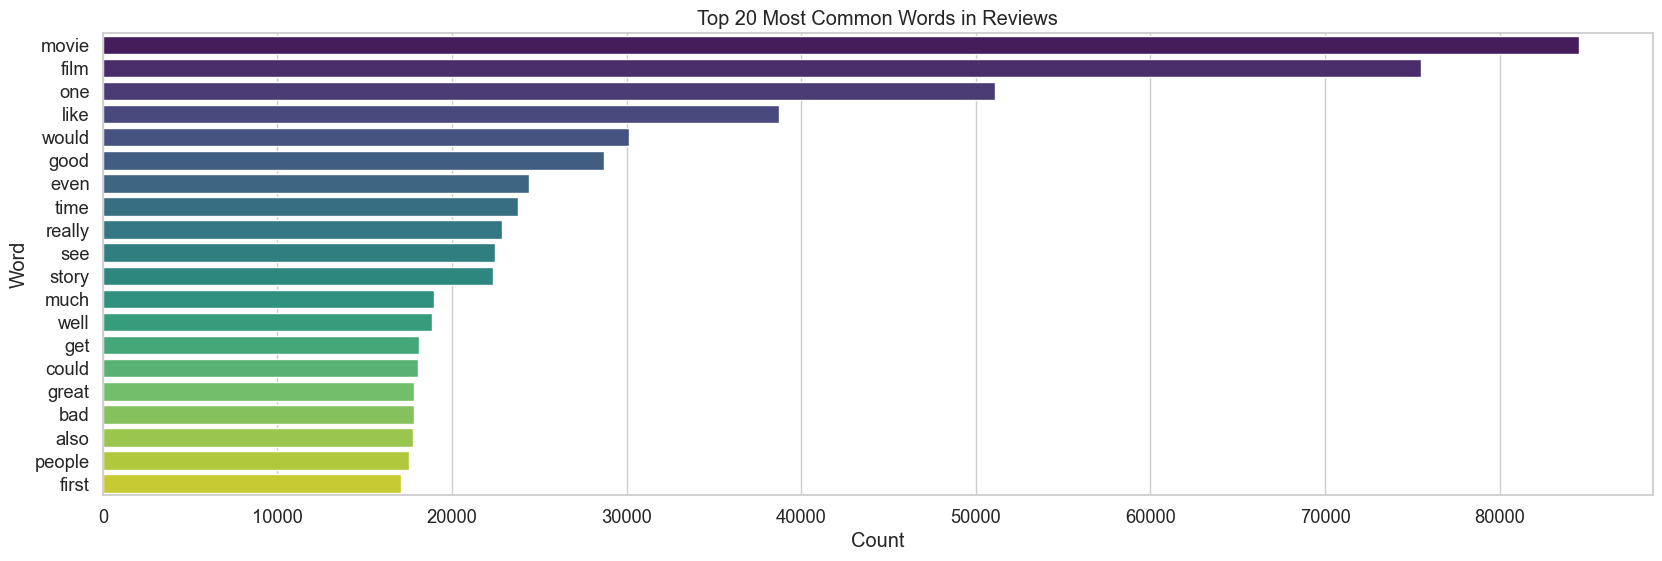

In [21]:
#plt.figure(figsize=(12,6))
sns.barplot(data=common_words_df, x="count", y="word", palette="viridis")
plt.title("Top 20 Most Common Words in Reviews")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()

In [22]:
# Positive reviews
pos_words = " ".join(data.loc[data["sentiment"] == 1, "review"]).split()
pos_freq = pd.DataFrame(Counter(pos_words).most_common(20), columns=["word", "count"])
pos_freq["sentiment"] = "Positive"

# Negative reviews
neg_words = " ".join(data.loc[data["sentiment"] == 0, "review"]).split()
neg_freq = pd.DataFrame(Counter(neg_words).most_common(20), columns=["word", "count"])
neg_freq["sentiment"] = "Negative"

# Combine
freq_df = pd.concat([pos_freq, neg_freq])

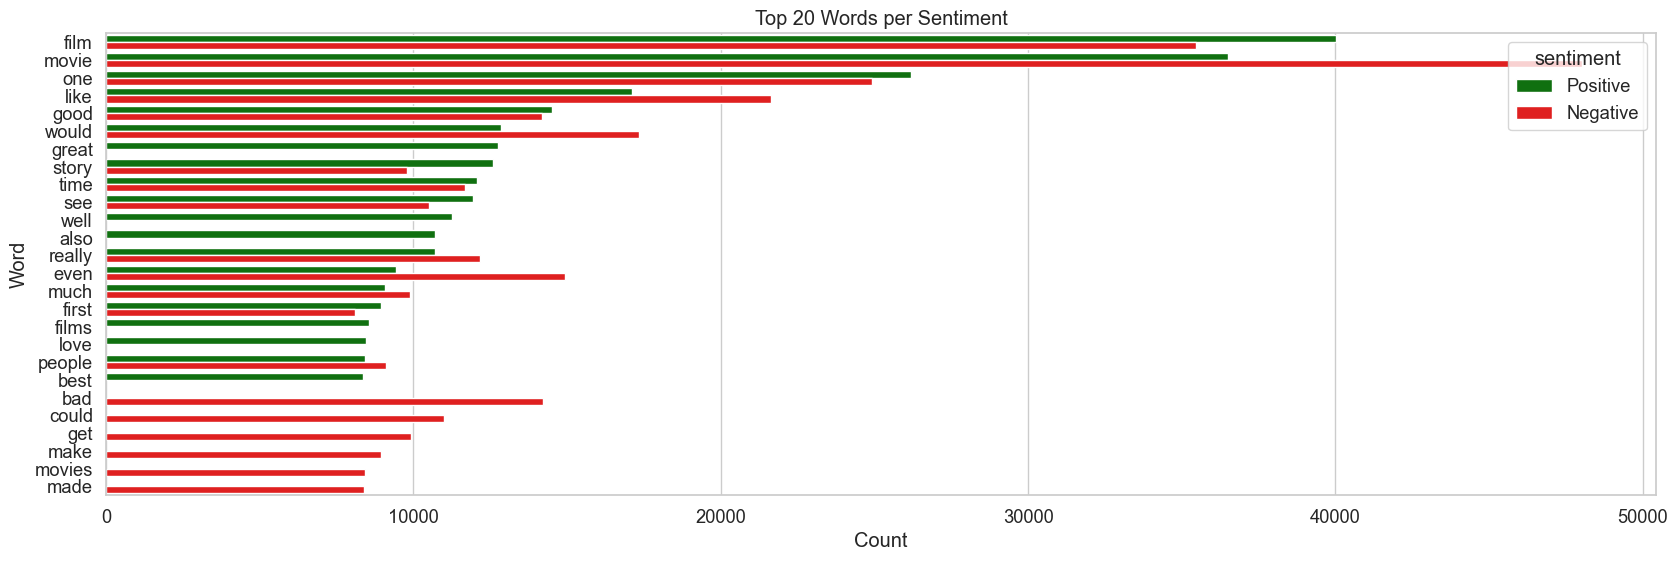

In [23]:
#plt.figure(figsize=(14,8))
sns.barplot(data=freq_df, x="count", y="word", hue="sentiment", palette={"Positive":"green", "Negative":"red"})
plt.title("Top 20 Words per Sentiment")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_bigrams(texts, top_n=20):
    vectorizer = CountVectorizer(ngram_range=(2,2), max_features=top_n)
    X = vectorizer.fit_transform(texts)
    bigram_counts = X.toarray().sum(axis=0)
    return pd.DataFrame({
        "bigram": vectorizer.get_feature_names_out(),
        "count": bigram_counts
    }).sort_values(by="count", ascending=False)

# Positive reviews bigrams
pos_bigrams_df = get_top_bigrams(data.loc[data["sentiment"] == 1, "review"])
pos_bigrams_df["sentiment"] = "Positive"

# Negative reviews bigrams
neg_bigrams_df = get_top_bigrams(data.loc[data["sentiment"] == 0, "review"])
neg_bigrams_df["sentiment"] = "Negative"

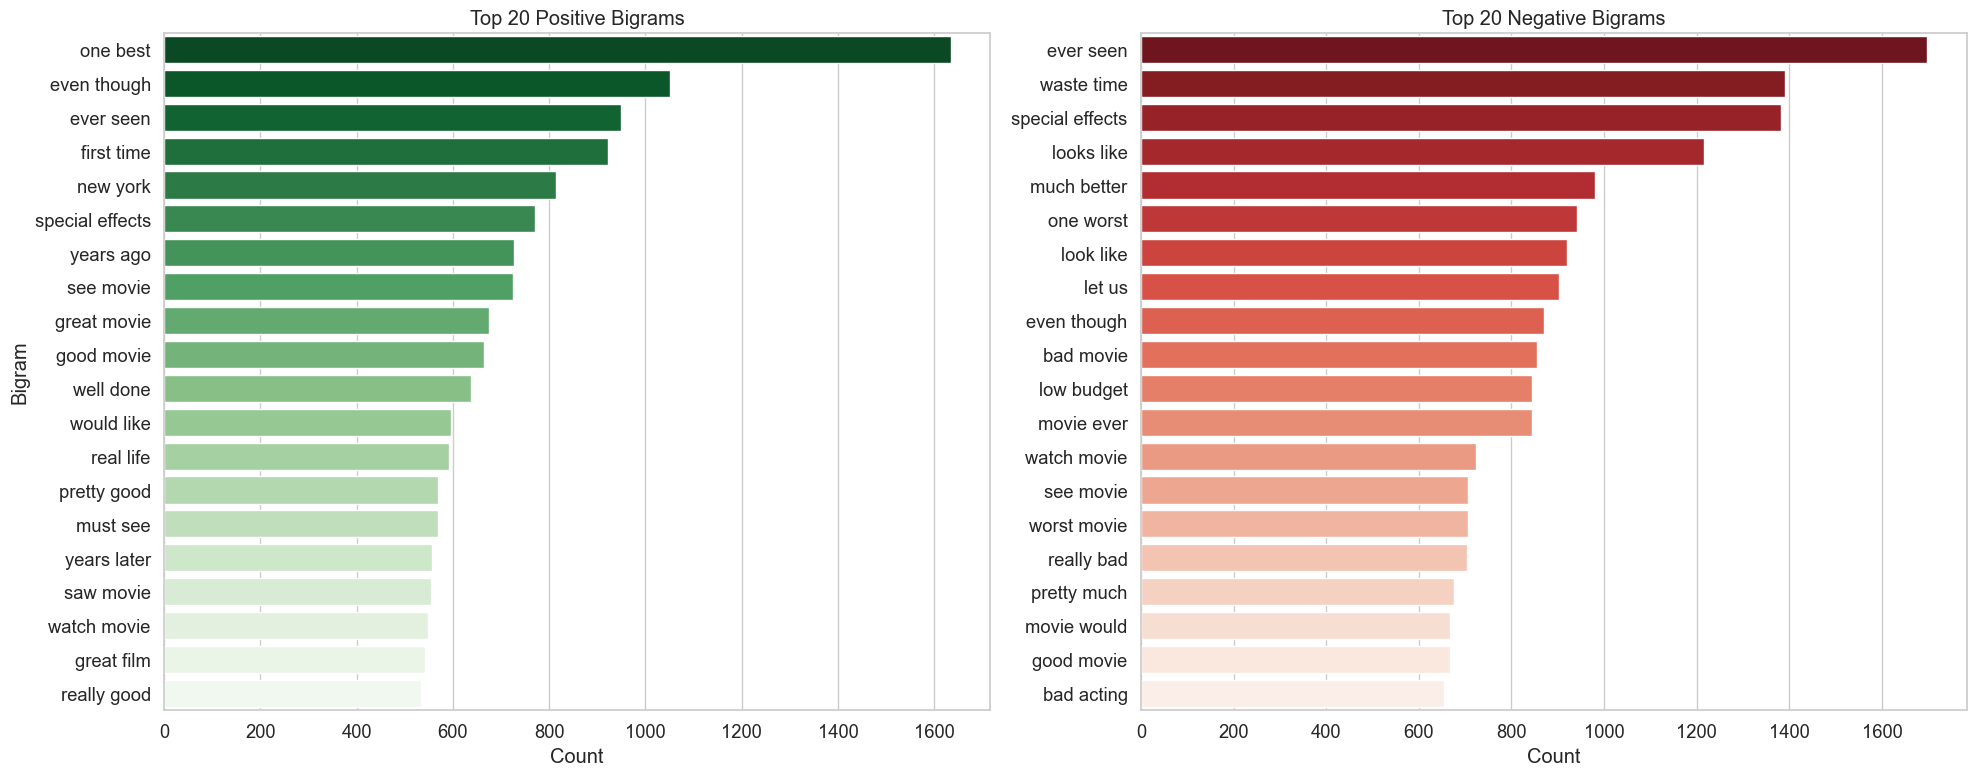

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharex=False, sharey=False)

sns.barplot(data=pos_bigrams_df, x="count", y="bigram", palette="Greens_r", ax=axes[0])
axes[0].set_title("Top 20 Positive Bigrams")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Bigram")

sns.barplot(data=neg_bigrams_df, x="count", y="bigram", palette="Reds_r", ax=axes[1])
axes[1].set_title("Top 20 Negative Bigrams")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

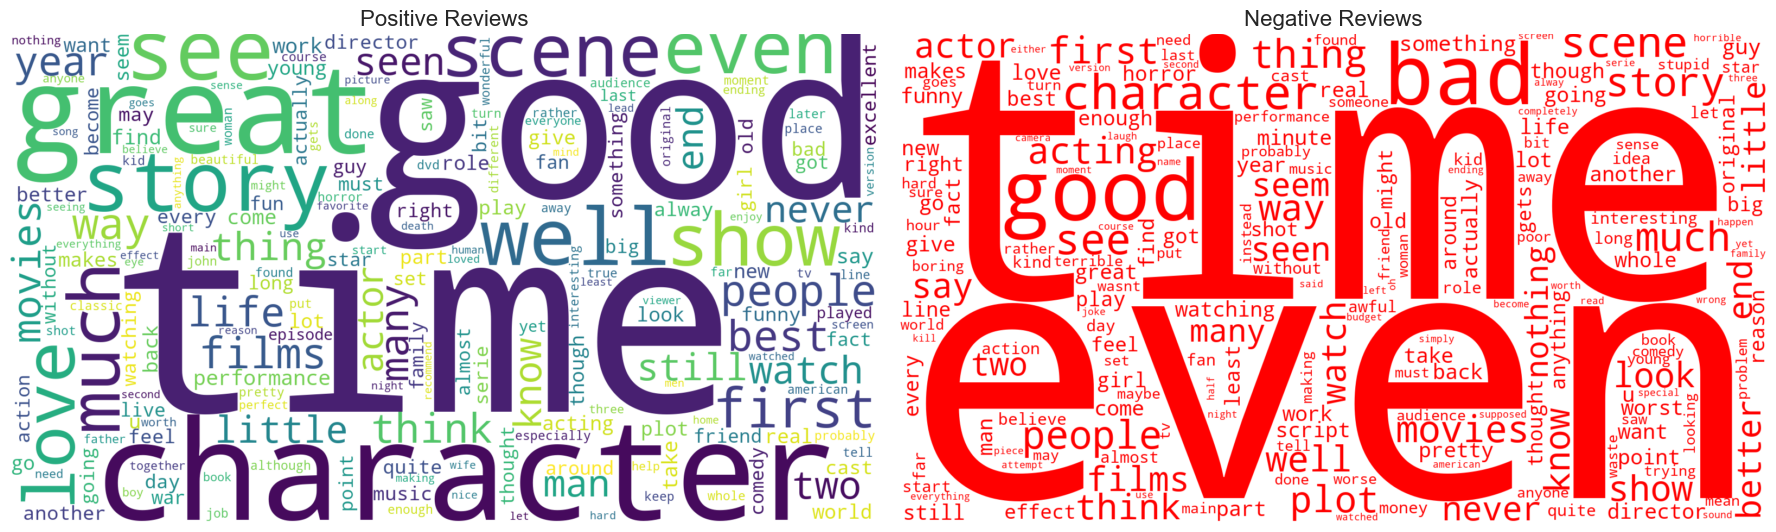

In [26]:
extra_stops = {"movie", "film", "one", "really", "make", "made"}
stops = STOPWORDS.union(extra_stops)

pos_text = " ".join(data.loc[data["sentiment"] == 1, "review"].astype(str))
neg_text = " ".join(data.loc[data["sentiment"] == 0, "review"].astype(str))

wc_pos = WordCloud(
    width=1600, height=900, background_color="white",
    stopwords=stops, collocations=False, random_state=42
).generate(pos_text)

wc_neg = WordCloud(
    width=1600, height=900, background_color="white",
    stopwords=stops, collocations=False, random_state=42
).generate(neg_text)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.imshow(wc_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Reviews", fontsize=16)

plt.subplot(1, 2, 2)
plt.imshow(wc_neg.recolor(color_func=lambda *args, **kw: "red"), interpolation="bilinear")
plt.axis("off")
plt.title("Negative Reviews", fontsize=16)

plt.tight_layout()
plt.show()

In [27]:
from preprocessor.pos_tag import compute_pos_stats

texts = data["review"].tolist()
labels = data["sentiment"].tolist()

pos_df = compute_pos_stats(texts, labels)

POS tagging:   0%|          | 0/49582 [00:00<?, ?it/s]

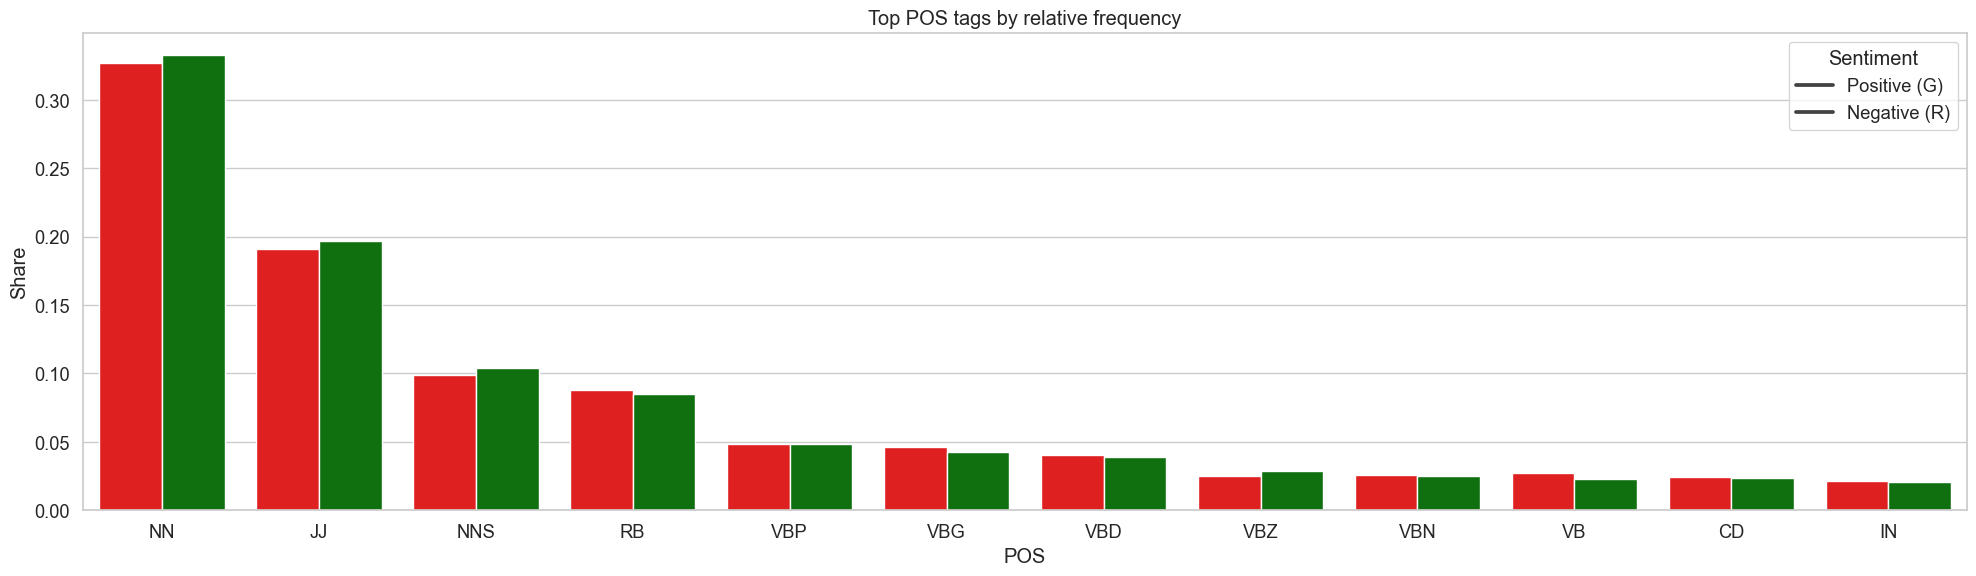

In [28]:
top_k = 12
order = (
    pos_df.groupby("pos")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(top_k)
    .index.tolist()
)

#plt.figure(figsize=(12, 6))
sns.barplot(
    data=pos_df[pos_df["pos"].isin(order)],
    x="pos",
    y="pct",
    hue="sentiment",
    order=order,
    palette={1: "green", 0: "red"},
)
plt.title("Top POS tags by relative frequency")
plt.xlabel("POS")
plt.ylabel("Share")
plt.legend(title="Sentiment", labels=["Positive (G)", "Negative (R)"])
plt.tight_layout()
plt.show()

In [29]:
out = data[["review", "sentiment"]].astype({"sentiment": "int8"})
project_root = notebook_dir.parent
data_dir = project_root / "data"

out.to_parquet(
    data_dir / "imdb_reviews.parquet",
    index=False,
    engine="fastparquet"
)